In [1]:
import os 
import glob

import numpy as np
import scikit_posthocs as sp
import scipy.stats as ss
import pandas as pd
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [2]:
cols_baard = [
    '#d7a532',  # Stage 1  
    '#328dee',  # Stage 2
    '#80d358'   # Stage 3
]

name_nicely = {
    "banknote": "Banknote",
    "breastcancer": "BrCancer",
    "cifar10": "CIFAR-10",
    "htru2": "HTRU2",
    "mnist": "MNIST",
    "dnn": "DNN",
    "resnet": "ResNet",
    "svm": "SVM",
    "tree": "Tree",
    "vgg": "VGG",
    "baard": "BAARD",
    "fs": "FS",
    "lid": "LID",
    "magnet": "MagNet",
    "rc": "RC"
}


In [3]:
def read_baard_results(data, model, attacks):
    list_df = []
    for i in range(5):
        for a in attacks:
            path = os.path.join(
                '..','results', 'result_{}'.format(i), '{}_{}'.format(data, model), 'results', 
                '{}_{}_{}_baard.csv'.format(data, model, a))
            df = pd.read_csv(path)
            df = df.drop('Unnamed: 0', axis=1)
            list_df.append(df)
    df = pd.concat(list_df, axis=0, ignore_index=True)
    df['data'] = df['data'].map(name_nicely)
    df['model'] = df['model'].map(name_nicely)
    return df

In [4]:
attacks = ['fgsm', 'apgd', 'apgd2', 'cw2', 'boundary']
banknote = read_baard_results('banknote', 'dnn', attacks)
banknote.head()

,data,model,attack,adv_param,acc_no_def,acc_on_adv_1,fpr_1,acc_on_adv_2,fpr_2,acc_on_adv_3,fpr_3
0,Banknote,DNN,fgsm,0.05,0.688442,0.698492,0.0,0.909548,0.0,0.924623,0.0
1,Banknote,DNN,fgsm,0.10,0.145729,0.251256,0.0,0.703518,0.0,0.718593,0.0
2,Banknote,DNN,fgsm,0.30,0.000000,0.366834,0.0,0.974874,0.0,0.974874,0.0
3,Banknote,DNN,fgsm,0.60,0.000000,0.809045,0.0,1.000000,0.0,1.000000,0.0
4,Banknote,DNN,fgsm,1.00,0.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0


In [5]:
banknote.columns

Index(['data', 'model', 'attack', 'adv_param', 'acc_no_def', 'acc_on_adv_1',
       'fpr_1', 'acc_on_adv_2', 'fpr_2', 'acc_on_adv_3', 'fpr_3'],
      dtype='object')

In [6]:
cols = ['acc_no_def', 'acc_on_adv_1', 'fpr_1', 
    'acc_on_adv_2', 'fpr_2', 'acc_on_adv_3', 'fpr_3']
banknote[cols] = banknote[cols].multiply(100.0)

banknote.head()

,data,model,attack,adv_param,acc_no_def,acc_on_adv_1,fpr_1,acc_on_adv_2,fpr_2,acc_on_adv_3,fpr_3
0,Banknote,DNN,fgsm,0.05,68.844221,69.849246,0.0,90.954774,0.0,92.462312,0.0
1,Banknote,DNN,fgsm,0.10,14.572864,25.125628,0.0,70.351759,0.0,71.859296,0.0
2,Banknote,DNN,fgsm,0.30,0.000000,36.683417,0.0,97.487437,0.0,97.487437,0.0
3,Banknote,DNN,fgsm,0.60,0.000000,80.904523,0.0,100.000000,0.0,100.000000,0.0
4,Banknote,DNN,fgsm,1.00,0.000000,100.000000,0.0,100.000000,0.0,100.000000,0.0


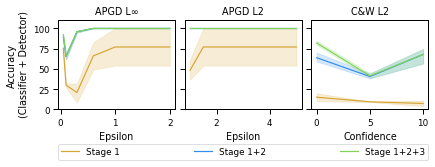

In [8]:
hue_order = ['Stage 1', 'Stage 1+2', 'Stage 1+2+3']
cols = ['data', 'model', 'attack', 'adv_param', 'acc_no_def', 
    'acc_on_adv_1', 'acc_on_adv_2', 'acc_on_adv_3']
stage_names = {
    'acc_on_adv_1': 'Stage 1',
    'acc_on_adv_2': 'Stage 1+2',
    'acc_on_adv_3': 'Stage 1+2+3',
}

sns.set_context('paper')
fig, ax = plt.subplots(1, 3, figsize=(6, 2))

apgd = banknote[(banknote['attack'] == 'apgd')]
acc0 = apgd[cols].melt(['data', 'model', 'attack', 'adv_param', 'acc_no_def'], 
    var_name='Stage', value_name='acc_on_adv')
acc0['Stage'] = acc0['Stage'].map(stage_names)
s0 = sns.lineplot(x='adv_param', y='acc_on_adv', hue='Stage',
    palette=cols_baard, data=acc0, hue_order=hue_order, ax=ax[0])
s0.set(xlabel='Epsilon', ylabel="Accuracy\n (Classifier + Detector)")
s0.legend_.remove()
ax[0].set(ylim=(0., 110.))
ax[0].set_title('APGD L\u221e')

apgd2 = banknote[(banknote['attack'] == 'apgd2')]
acc1 = apgd2[cols].melt(['data', 'model', 'attack', 'adv_param', 'acc_no_def'], 
    var_name='Stage', value_name='acc_on_adv')
acc1['Stage'] = acc1['Stage'].map(stage_names)
s1 = sns.lineplot(x='adv_param', y='acc_on_adv', hue='Stage',
    palette=cols_baard, data=acc1, hue_order=hue_order, ax=ax[1])
s1.set(xlabel='Epsilon', ylabel=None, yticklabels=[])
s1.legend_.remove()
ax[1].set(ylim=(0., 110.))
ax[1].set_title('APGD L2')

cw2 = banknote[(banknote['attack'] == 'cw2')]
acc2 = cw2[cols].melt(['data', 'model', 'attack', 'adv_param', 'acc_no_def'], 
    var_name='Stage', value_name='acc_on_adv')
acc2['Stage'] = acc2['Stage'].map(stage_names)
s2 = sns.lineplot(x='adv_param', y='acc_on_adv', hue='Stage',
    palette=cols_baard, data=acc2, hue_order=hue_order, ax=ax[2])
s2.set(xlabel='Confidence', ylabel=None, yticklabels=[])
s2.legend_.remove()
ax[2].set(ylim=(0., 110.))
ax[2].set_title('C&W L2')

plt.tight_layout(pad=0.5)
bb = (
    fig.subplotpars.left, 
    fig.subplotpars.bottom - 0.35, 
    fig.subplotpars.right - fig.subplotpars.left,
    .1
)
plt.legend(bbox_to_anchor=bb, loc='lower left', ncol=5, mode="expand", 
    borderaxespad=0., bbox_transform=fig.transFigure)
plt.savefig('lineplot_banknote_baard.pdf', format='pdf', dpi=1200, bbox_inches='tight')